In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [2]:
# Label remapping

label_map = {
    'Not Drowsy': 'alert', 'Slight': 'slightly', 'Moderate': 'moderate_very', 'Very': 'moderate_very'
}

# Feature list
features = [
    'EAR_mean', 'MAR_inner', 'MAR_outer',
    'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
    'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz',
    'gaze_angle_x', 'gaze_angle_y',
    'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'
]

In [3]:
import os
import pandas as pd
from pycatch22 import catch22_all
from tqdm import tqdm

# Paths
data_dir = 'Classification_Combined_Data/Combined_S1S2_clean'
output_dir = 'Classification_Combined_Data'
os.makedirs(output_dir, exist_ok=True)

# Train/test IDs
train_ids= ['S1_P13', 'S1_P04', 'S1_P27', 'S2_P24', 'S1_P18', 'S2_P45', 'S1_P23',
'S2_P15', 'S1_P11', 'S1_P29', 'S2_P30', 'S2_P35', 'S1_P33', 'S2_P29', 'S1_P21', 'S1_P20',
#'S2_P04', #labels missing
'S1_P16', 'S2_P17', 'S2_P19', 'S1_P34', 'S2_P44', 'S1_P12', 'S2_P27', 'S1_P08', 'S1_P03',
'S1_P14', 'S2_P42', 'S2_P31', 'S2_P21', 'S1_P32', 'S2_P18', 'S2_P46', 'S2_P37',
'S2_P28', 'S2_P36', 'S2_P38', 'S1_P24', 'S2_P32', 'S1_P26', 'S1_P28', 'S2_P26', 'S2_P33', #'S2_P23', #labels missing
'S2_P43', 'S2_P34', 'S1_P07', 'S1_P05', 'S1_P17', 'S1_P09', 'S2_P09']
 
test_ids = ['S2_P12', 'S1_P15', 'S1_P31',
#'S2_P22', ## labels missing
'S1_P19', 'S2_P39', 'S2_P48', 'S1_P35', 'S2_P40',
'S2_P41', 'S2_P49', 'S1_P10', 'S2_P13']

# Metadata and selected time-series features (20 total)
metadata_cols = ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']
timeseries_features = [
    'EAR_mean', 'MAR_inner', 'MAR_outer',
    'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
    'pose_Tx', 'pose_Ty', 'pose_Tz',
    'pose_Rx', 'pose_Ry', 'pose_Rz',
    'gaze_angle_x', 'gaze_angle_y',
    'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'
]

# Window parameters
window_size = 30
stride = 15

def extract_catch22_features(signal, prefix):
    features = catch22_all(signal)['values']
    names = [f"{prefix}_{name}" for name in catch22_all(signal)['names']]
    return pd.Series(features, index=names)

def process_file_with_catch22(file_path, file_id):
    df = pd.read_csv(file_path)
    df = df[metadata_cols + timeseries_features]
    results = []

    start_time = df['UNIX'].min()
    end_time = df['UNIX'].max()
    current_start = start_time

    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        group = df[(df['UNIX'] >= current_start) & (df['UNIX'] < window_end)]

        if group.empty:
            current_start += stride
            continue

        # Label check
        label_vals = group['Label_unify'].dropna().unique()
        if len(label_vals) != 1:
            current_start += stride
            continue

        label = label_vals[0]
        first_row = group.iloc[0][metadata_cols]

        # Extract features
        all_feats = []
        for feat in timeseries_features:
            ts_data = group[feat].dropna().values
            if len(ts_data) < 10:
                # Not enough points to extract meaningful features
                all_feats.append(pd.Series([None] * 22, index=[f"{feat}_f{i}" for i in range(22)]))
            else:
                all_feats.append(extract_catch22_features(ts_data, feat))

        full_row = pd.concat([first_row, *all_feats])
        results.append(full_row)

        current_start += stride

    return results

# Process all files
train_rows, test_rows = [], []

print("\n🚀 Starting Catch22 feature extraction...")
for file in tqdm(os.listdir(data_dir)):
    if not file.endswith('.csv'):
        continue

    file_id = file.replace('.csv', '')
    file_path = os.path.join(data_dir, file)

    rows = process_file_with_catch22(file_path, file_id)

    if file_id in train_ids:
        train_rows.extend(rows)
    elif file_id in test_ids:
        test_rows.extend(rows)

# Convert to DataFrame and save
train_df = pd.DataFrame(train_rows)
test_df = pd.DataFrame(test_rows)

print(f"\n✅ Final TRAIN shape: {train_df.shape}")
print(f"✅ Final TEST shape: {test_df.shape}")

train_df.to_csv(os.path.join(output_dir, 'S1_S2_train_catch22.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'S1_S2_test_catch22.csv'), index=False)


🚀 Starting Catch22 feature extraction...


100%|██████████| 61/61 [04:23<00:00,  4.31s/it]



✅ Final TRAIN shape: (8957, 445)
✅ Final TEST shape: (2038, 445)


📊 Class distribution before SMOTE:
Label_unify
drowsy    7324
alert     1633
Name: count, dtype: int64


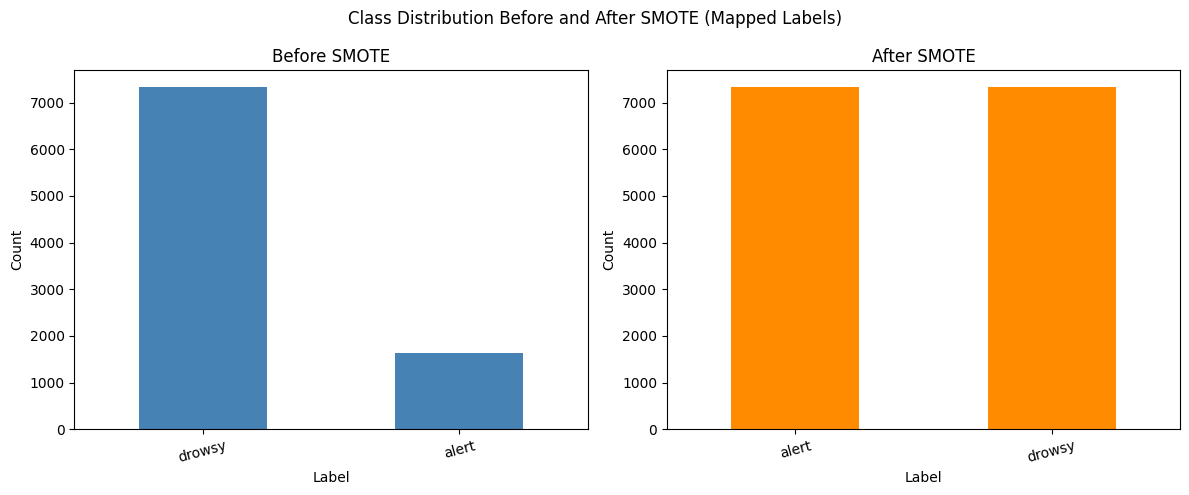

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# === Load original dataset ===
df = pd.read_csv('Classification_Combined_Data/S1_S2_train_catch22.csv')

# === Define label map ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}
df['Label_unify'] = df['Label_unify'].map(label_map)

# === Drop metadata columns ===
feature_cols = [col for col in df.columns if col not in ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']]
X = df[feature_cols].fillna(0)  # <-- Replace NaN with 0 here
y = df['Label_unify']

# === Encode remapped labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Class distribution BEFORE SMOTE ===
print("📊 Class distribution before SMOTE:")
print(y.value_counts())

# === Apply SMOTE ===
smote = SMOTE(random_state=42)
X_sm, y_sm_enc = smote.fit_resample(X, y_enc)
y_sm = le.inverse_transform(y_sm_enc)

# === Combine features + labels ===
X_sm_df = pd.DataFrame(X_sm, columns=feature_cols)
y_sm_df = pd.Series(y_sm, name='Label')
df_sm = pd.concat([y_sm_df, X_sm_df], axis=1)

# === Save oversampled dataset ===
# df_sm.to_csv('Classification_Combined_Data/S1_S2_train_data_c22_SMOTE_mapped.csv', index=False)
# print("\n✅ Mapped + SMOTEd data saved to: S1_S2_train_data_c22_SMOTE_mapped.csv")

# === Plot distributions ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
y.value_counts().plot(kind='bar', ax=ax[0], title='Before SMOTE', color='steelblue')
pd.Series(y_sm).value_counts().plot(kind='bar', ax=ax[1], title='After SMOTE', color='darkorange')

for a in ax:
    a.set_xlabel("Label")
    a.set_ylabel("Count")
    a.tick_params(axis='x', rotation=15)

plt.suptitle("Class Distribution Before and After SMOTE (Mapped Labels)")
plt.tight_layout()
plt.show()

🔍 Original train labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
🔍 Original test labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
✅ Train rows after mapping: 8957
✅ Test rows after mapping: 2038
✅ X_train shape: (8957, 440)
✅ X_test shape: (2038, 440)

📊 Dummy Classifier (Catch22 Features):
              precision    recall  f1-score   support

       alert       0.29      0.20      0.24       535
      drowsy       0.74      0.83      0.78      1503

    accuracy                           0.66      2038
   macro avg       0.52      0.51      0.51      2038
weighted avg       0.62      0.66      0.64      2038



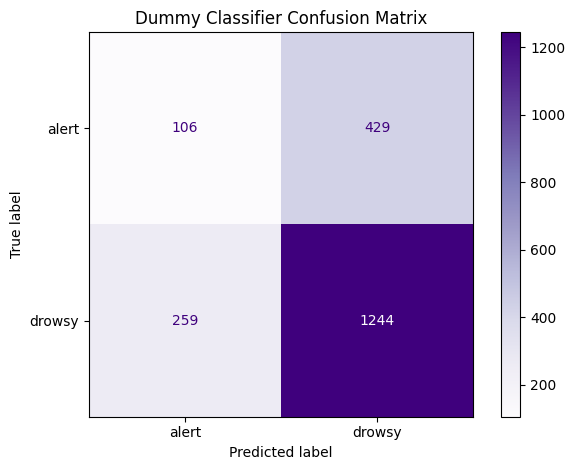

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# === FILE PATHS ===
train_path = 'Classification_Combined_Data/S1_S2_train_catch22.csv'
test_path = 'Classification_Combined_Data/S1_S2_test_catch22.csv'

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === LOAD DATA ===
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("🔍 Original train labels:", train_df['Label_unify'].unique())
print("🔍 Original test labels:", test_df['Label_unify'].unique())

# === APPLY MAPPING ONLY IF NEEDED ===
def map_labels(df):
    # Only map if raw labels are still in old form
    if any(lbl in df['Label_unify'].unique() for lbl in label_map.keys()):
        df['Label_unify'] = df['Label_unify'].map(label_map)
    return df

train_df = map_labels(train_df)
test_df = map_labels(test_df)

train_df = train_df[train_df['Label_unify'].notna()]
test_df = test_df[test_df['Label_unify'].notna()]

print(f"✅ Train rows after mapping: {len(train_df)}")
print(f"✅ Test rows after mapping: {len(test_df)}")

# === FEATURE LIST (EXCLUDE METADATA) ===
# === Drop metadata columns ===
meta_cols = ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']
features = [col for col in train_df.columns if col not in meta_cols]

# === SPLIT X/y ===
X_train = train_df[features].fillna(0)
y_train = train_df['Label_unify']
X_test = test_df[features].fillna(0)
y_test = test_df['Label_unify']

# === LABEL ENCODING ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

print("✅ X_train shape:", X_train.shape)
print("✅ X_test shape:", X_test.shape)

# === DUMMY CLASSIFIER ===
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train_enc)
y_pred = dummy_clf.predict(X_test)

# === LABEL ORDERING ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [le.classes_.tolist().index(lbl) for lbl in custom_order if lbl in le.classes_]

# === REPORT ===
print("\n📊 Dummy Classifier (Catch22 Features):")
print(classification_report(
    y_test_enc,
    y_pred,
    labels=custom_label_indices,
    target_names=[le.classes_[i] for i in custom_label_indices]
))

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred,
    labels=custom_label_indices,
    display_labels=[le.classes_[i] for i in custom_label_indices],
    cmap='Purples'
)
plt.title("Dummy Classifier Confusion Matrix")
plt.tight_layout()
plt.show()

🔍 Original train labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
🔍 Original test labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
✅ Train rows after mapping: 8957
✅ Test rows after mapping: 2038

📊 Random Forest (Catch22 Features):
              precision    recall  f1-score   support

       alert       0.49      0.07      0.12       535
      drowsy       0.75      0.98      0.85      1503

    accuracy                           0.74      2038
   macro avg       0.62      0.52      0.48      2038
weighted avg       0.68      0.74      0.65      2038

Balanced F1 Score (macro): 0.4805
Balanced F1 Score (weighted): 0.6539
ROC AUC: 0.6624


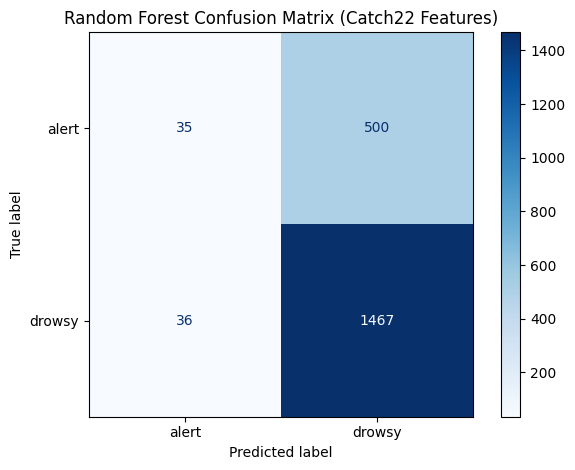

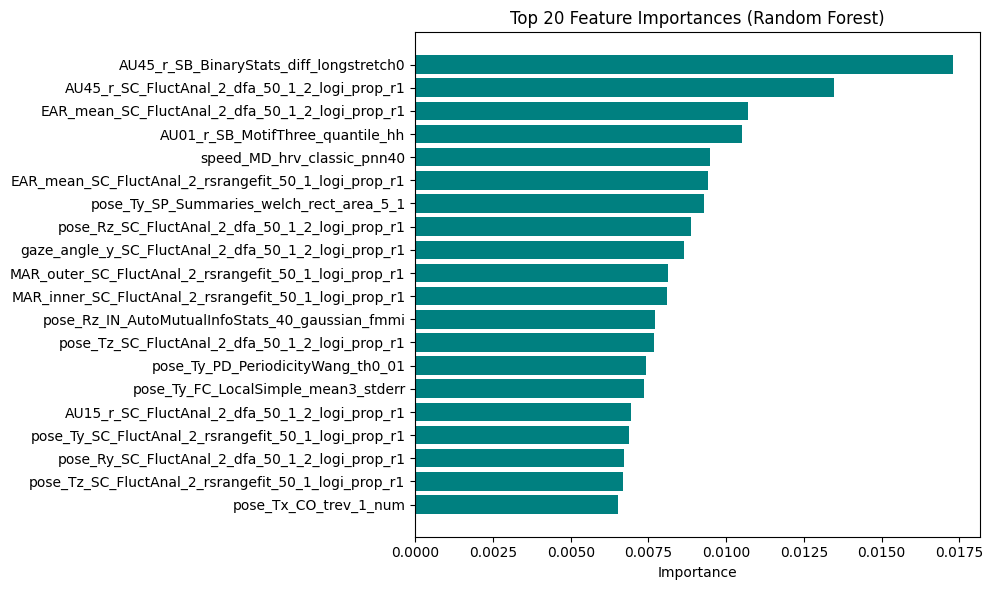

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE

# === FILE PATHS ===
train_path = 'Classification_Combined_Data/S1_S2_train_catch22.csv'
test_path = 'Classification_Combined_Data/S1_S2_test_catch22.csv'

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === LOAD DATA ===
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("🔍 Original train labels:", train_df['Label_unify'].unique())
print("🔍 Original test labels:", test_df['Label_unify'].unique())

# === APPLY MAPPING ONLY IF NEEDED ===
def map_labels(df):
    if any(lbl in df['Label_unify'].unique() for lbl in label_map.keys()):
        df['Label_unify'] = df['Label_unify'].map(label_map)
    return df

train_df = map_labels(train_df)
test_df = map_labels(test_df)

train_df = train_df[train_df['Label_unify'].notna()]
test_df = test_df[test_df['Label_unify'].notna()]

print(f"✅ Train rows after mapping: {len(train_df)}")
print(f"✅ Test rows after mapping: {len(test_df)}")

# === FEATURE SELECTION ===
non_features = ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features].fillna(0)
y_train = train_df['Label_unify']
X_test = test_df[features].fillna(0)
y_test = test_df['Label_unify']

# === ENCODE LABELS (TRAIN+TEST UNION) ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# === SMOTE BALANCING (OPTIONAL — ALREADY SMOTE IN TRAIN FILE, SKIP IF YOU WANT) ===
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)
# print("✅ After SMOTE:", np.bincount(y_train_sm))

# # Use directly (since SMOTE already applied during feature creation)
# X_train_sm, y_train_sm = X_train, y_train_enc

# === TRAIN RANDOM FOREST ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_sm, y_train_sm)

# === PREDICT ===
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)

# === CUSTOM LABEL ORDER ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [le.classes_.tolist().index(lbl) for lbl in custom_order if lbl in le.classes_]

# === CLASSIFICATION REPORT ===
print("\n📊 Random Forest (Catch22 Features):")
print(classification_report(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    target_names=[le.classes_[i] for i in custom_label_indices]
))

# === F1 SCORES ===
f1_macro = f1_score(y_test_enc, y_pred_rf, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_rf, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# === ROC-AUC (Handles multi-class automatically) ===
if len(le.classes_) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba_rf[:, 1])
else:
    auc_score = roc_auc_score(y_test_enc, y_proba_rf, multi_class='ovr', average='macro')

print(f"ROC AUC: {auc_score:.4f}")

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    display_labels=[le.classes_[i] for i in custom_label_indices],
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Catch22 Features)")
plt.tight_layout()
plt.show()

# === FEATURE IMPORTANCE ===
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# === Plot top 20 features ===
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1], color='teal')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

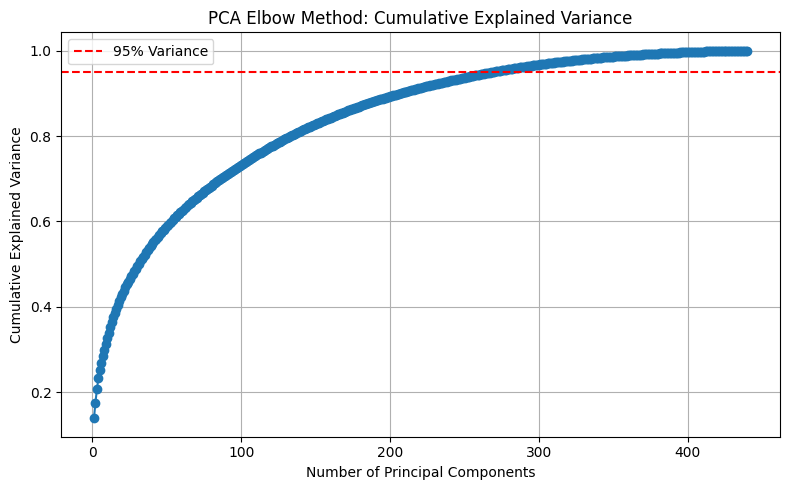

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# === Standardize before PCA ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_sm)

# === PCA ===
pca = PCA()
pca.fit(X_scaled)

# === Elbow plot ===
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title("PCA Elbow Method: Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Classifier Report:
              precision    recall  f1-score   support

       alert       0.40      0.11      0.17       535
      drowsy       0.75      0.94      0.83      1503

    accuracy                           0.72      2038
   macro avg       0.57      0.52      0.50      2038
weighted avg       0.66      0.72      0.66      2038

Balanced F1 Score (macro): 0.5020
Balanced F1 Score (weighted): 0.6595
ROC AUC: 0.6290


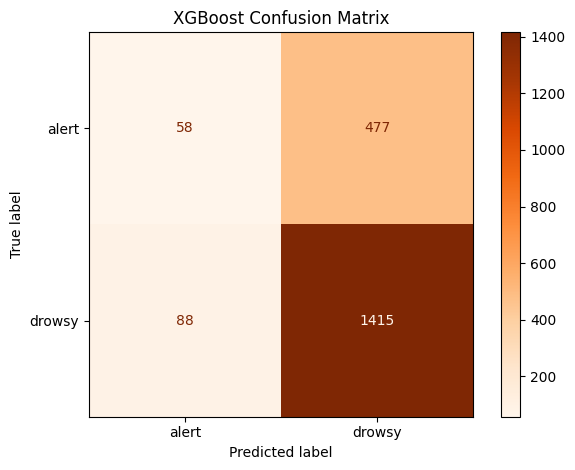

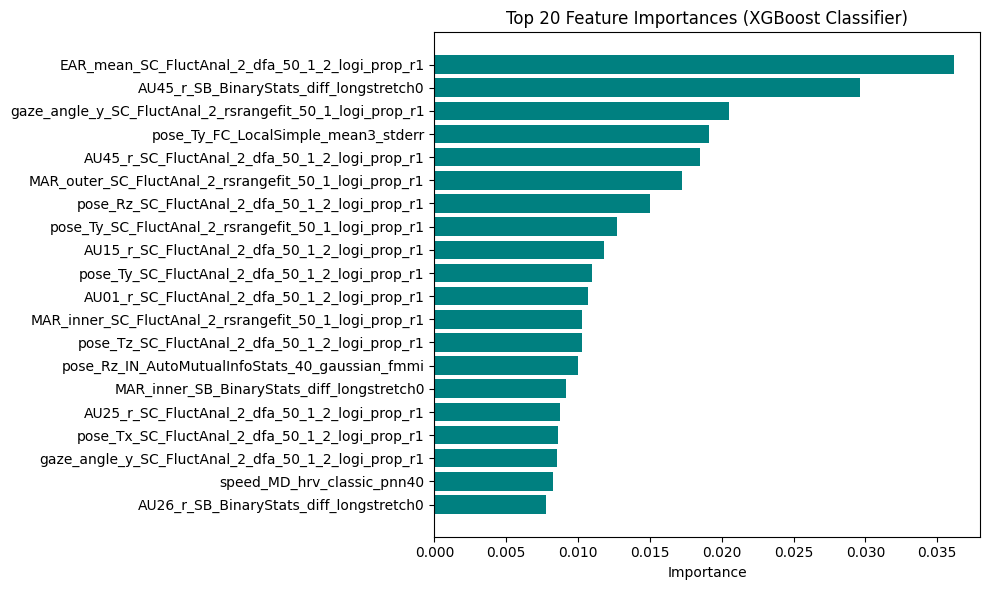

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === FILE PATHS ===
train_path = 'Classification_Combined_Data/S1_S2_train_catch22.csv'
test_path = 'Classification_Combined_Data/S1_S2_test_catch22.csv'

# === LOAD DATA ===
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# === MAP LABELS ===
train_df['Label_unify'] = train_df['Label_unify'].map(label_map)
test_df['Label_unify'] = test_df['Label_unify'].map(label_map)
train_df = train_df[train_df['Label_unify'].notna()]
test_df = test_df[test_df['Label_unify'].notna()]

# === FEATURES ===
meta_cols = ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']
features = [col for col in train_df.columns if col not in meta_cols]

# === SPLIT X/y ===
X_train = train_df[features].fillna(0)
y_train = train_df['Label_unify']
X_test = test_df[features].fillna(0)
y_test = test_df['Label_unify']

# === LABEL ENCODING ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# === SMOTE BALANCING ===
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

# === XGBOOST CLASSIFIER ===
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(X_train_sm, y_train_sm)

# === PREDICTIONS ===
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)

# === METRICS ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

print("\n📊 XGBoost Classifier Report:")
print(classification_report(
    y_test_enc,
    y_pred,
    labels=custom_label_indices,
    target_names=custom_order
))

f1_macro = f1_score(y_test_enc, y_pred, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

if len(np.unique(y_test_enc)) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba[:, 1])
else:
    auc_score = roc_auc_score(y_test_enc, y_proba, multi_class='ovr', average='macro')
print(f"ROC AUC: {auc_score:.4f}")

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Oranges'
)
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.show()

# === FEATURE IMPORTANCE ===
importances = xgb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# === Plot top 20 features ===
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1], color='teal')
plt.title("Top 20 Feature Importances (XGBoost Classifier)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Iteration 1, loss = 1.63967394
Validation score: 0.627133
Iteration 2, loss = 0.79726816
Validation score: 0.667235
Iteration 3, loss = 0.65932819
Validation score: 0.691126
Iteration 4, loss = 0.60700166
Validation score: 0.722696
Iteration 5, loss = 0.54628787
Validation score: 0.737201
Iteration 6, loss = 0.51081803
Validation score: 0.734642
Iteration 7, loss = 0.49156225
Validation score: 0.744027
Iteration 8, loss = 0.46448070
Validation score: 0.773891
Iteration 9, loss = 0.46107521
Validation score: 0.761092
Iteration 10, loss = 0.42525415
Validation score: 0.777304
Iteration 11, loss = 0.40991527
Validation score: 0.786689
Iteration 12, loss = 0.40130593
Validation score: 0.755973
Iteration 13, loss = 0.38391919
Validation score: 0.795222
Iteration 14, loss = 0.36212493
Validation score: 0.802901
Iteration 15, loss = 0.35359244
Validation score: 0.813993
Iteration 16, loss = 0.33379701
Validation score: 0.806314
Iteration 17, loss = 0.32157344
Validation score: 0.794369
Iterat

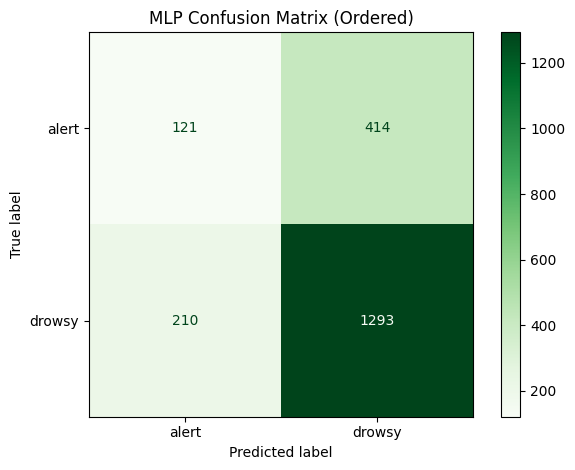

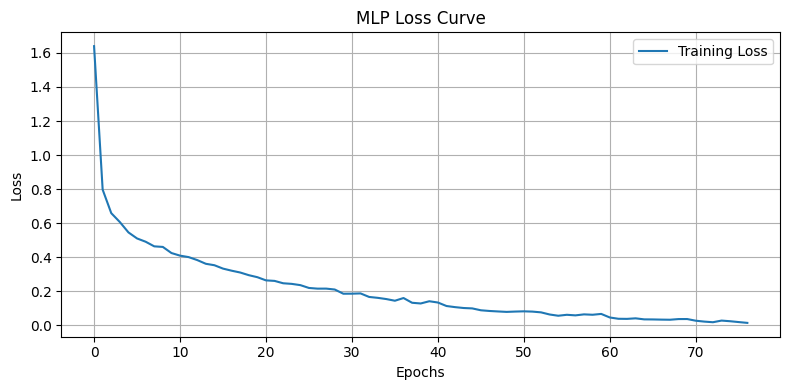

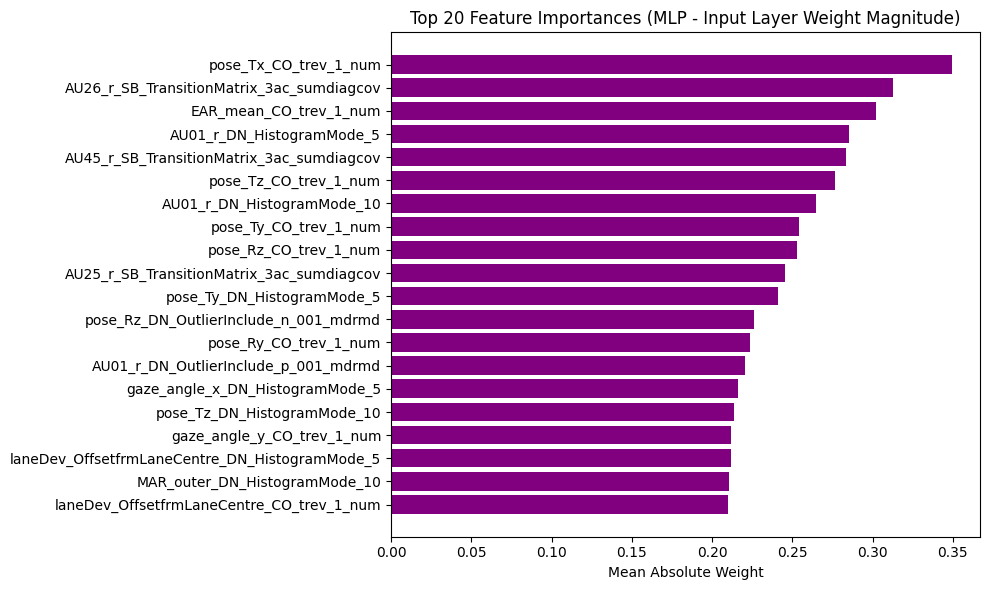

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === LOAD C22 DATA ===
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_catch22.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_catch22.csv')

train_df['Label_unify'] = train_df['Label_unify'].map(label_map)
test_df['Label_unify'] = test_df['Label_unify'].map(label_map)

train_df = train_df[train_df['Label_unify'].notna()]
test_df = test_df[test_df['Label_unify'].notna()]

# === EXTRACT FEATURES & LABELS ===
non_features = ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features].fillna(0)
y_train = train_df['Label_unify']
X_test = test_df[features].fillna(0)
y_test = test_df['Label_unify']

# === LABEL ENCODING ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# === SMOTE BALANCING ===
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

# === VALIDATION SPLIT ===
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_sm, y_train_sm, test_size=0.2, random_state=42, stratify=y_train_sm
)

# === DEFINE MLP MODEL ===
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=100,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

# === FIT ===
mlp.fit(X_tr, y_tr)

# === PREDICT ON TEST ===
y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)

# === CUSTOM LABEL ORDER ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# === METRICS ===
print("MLP:\n")
print(classification_report(
    y_test_enc,
    y_pred_mlp,
    labels=custom_label_indices,
    target_names=custom_order
))

f1_macro = f1_score(y_test_enc, y_pred_mlp, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_mlp, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

if len(np.unique(y_test_enc)) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba_mlp[:, 1])
else:
    auc_score = roc_auc_score(y_test_enc, y_proba_mlp, multi_class='ovr', average='macro')
print(f"ROC AUC: {auc_score:.4f}")

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_mlp,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Greens'
)
plt.title("MLP Confusion Matrix (Ordered)")
plt.tight_layout()
plt.show()

# === LOSS CURVE ===
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Compute feature importance from input layer weights ===
input_weights = mlp.coefs_[0]  # weights between input layer and first hidden layer
feature_importance = np.mean(np.abs(input_weights), axis=1)  # average absolute weight per feature

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# === Plot top 20 features ===
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1], color='purple')
plt.title("Top 20 Feature Importances (MLP - Input Layer Weight Magnitude)")
plt.xlabel("Mean Absolute Weight")
plt.tight_layout()
plt.show()

In [ ]:
#Catch22 on all 20 features first
#Then from the 440 features run feature importance, select top xx and run the models again
#Elbow diagram to select number of features